In [1]:
!git clone "https://github.com/mims-harvard/GraphXAI.git"

^C


Cloning into 'GraphXAI'...
Updating files:   0% (194/25210)
Updating files:   1% (253/25210)
Updating files:   1% (397/25210)
Updating files:   2% (505/25210)
Updating files:   2% (570/25210)
Updating files:   3% (757/25210)
Updating files:   3% (921/25210)
Updating files:   3% (948/25210)
Updating files:   3% (954/25210)
Updating files:   3% (988/25210)
Updating files:   4% (1009/25210)
Updating files:   4% (1022/25210)
Updating files:   4% (1079/25210)
Updating files:   4% (1138/25210)
Updating files:   4% (1180/25210)
Updating files:   4% (1216/25210)
Updating files:   4% (1246/25210)
Updating files:   5% (1261/25210)
Updating files:   5% (1276/25210)
Updating files:   5% (1321/25210)
Updating files:   5% (1390/25210)
Updating files:   5% (1503/25210)
Updating files:   6% (1513/25210)
Updating files:   6% (1631/25210)
Updating files:   6% (1745/25210)
Updating files:   7% (1765/25210)
Updating files:   7% (1865/25210)
Updating files:   7% (1869/25210)
Updating files:   7% (1951/2521

In [1]:
!pip uninstall graphxai -y
!pip install -e "c:\users\lingg\onedrive\documents\tugas kuliah\ta\graphxai\graphxai"

Found existing installation: graphxai 0.1
Uninstalling graphxai-0.1:
  Successfully uninstalled graphxai-0.1
Obtaining file:///C:/users/lingg/onedrive/documents/tugas%20kuliah/ta/graphxai/graphxai
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for graphxai


  DEPRECATION: Legacy editable install of graphxai==0.1 from file:///C:/users/lingg/onedrive/documents/tugas%20kuliah/ta/graphxai/graphxai (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


In [10]:
!pip list | findstr graphxai

graphxai                 0.1       c:\users\lingg\onedrive\documents\tugas kuliah\ta\graphxai\graphxai


In [2]:
import sys
# Add the GraphXAI directory to Python path
sys.path.append(r'c:\users\lingg\onedrive\documents\tugas kuliah\ta\graphxai\graphxai')

In [11]:
import torch
import matplotlib.pyplot as plt
from graphxai.datasets import ShapeGGen

100%|██████████| 59/59 [00:00<00:00, 173.95it/s]


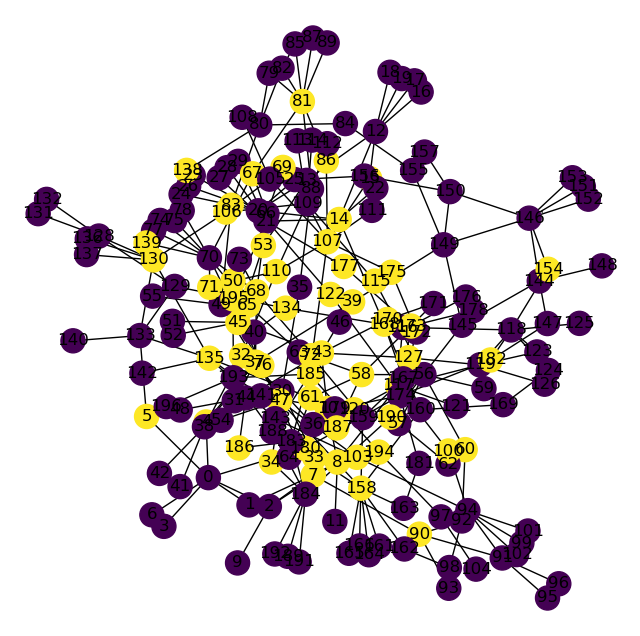

In [12]:
# Get dataset:
dataset = ShapeGGen(
    model_layers = 2,
    num_subgraphs = 15,
    subgraph_size = 13,
    prob_connection = 0.3,
    add_sensitive_feature = False
)

plt.figure(figsize = (8, 8))
dataset.visualize(show = True)

100%|██████████| 190/190 [00:02<00:00, 81.72it/s] 


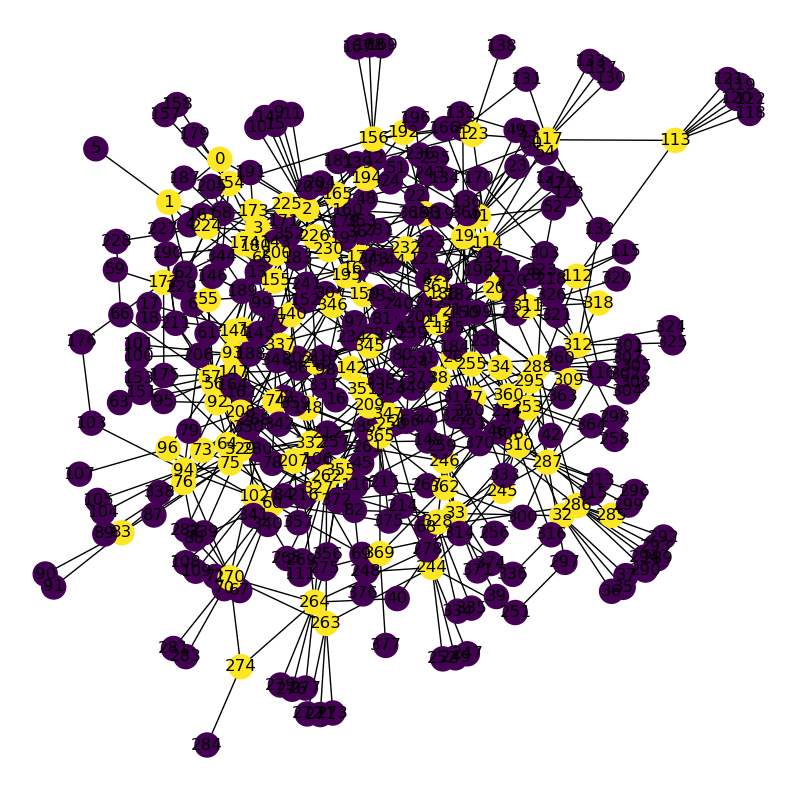

In [4]:
import random
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import graphxai
from graphxai.datasets import ShapeGGen

# 🔹 Fix random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 🔹 Create dataset with optimized connectivity
dataset = ShapeGGen(
    model_layers=3,
    num_subgraphs=20,
    subgraph_size=20,
    prob_connection=0.95,  # Increase connectivity
    base_graph='er',       # Use Erdos-Renyi for randomness
    variant=1,             # Preferential attachment
    add_sensitive_feature=False
)

# 🔹 Get the graph
G = dataset.G

# 🔹 Ensure all components are connected
components = list(nx.connected_components(G))
if len(components) > 1:
    for i in range(len(components) - 1):
        node1 = list(components[i])[0]  # Select node from first component
        node2 = list(components[i + 1])[0]  # Select node from next component
        G.add_edge(node1, node2)  # Force connection

# 🔹 Use spring layout with optimized parameters
pos = nx.spring_layout(G, k=0.12, iterations=2500, scale=1, center=(0, 0))

# 🔹 Plot graph
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos, node_color=[int(G.nodes[n]['shape'] > 0) for n in G.nodes], with_labels=True, ax=ax)

plt.show()



In [13]:
# Train a model from scratch on the data:
from torch_geometric.nn import GINConv

class MyGNN(torch.nn.Module):
    def __init__(self,input_feat, hidden_channels, classes = 2):
        super(MyGNN, self).__init__()
        self.mlp_gin1 = torch.nn.Linear(input_feat, hidden_channels)
        self.gin1 = GINConv(self.mlp_gin1)
        self.mlp_gin2 = torch.nn.Linear(hidden_channels, classes)
        self.gin2 = GINConv(self.mlp_gin2)

    def forward(self, x, edge_index):
        # NOTE: our provided testing function assumes no softmax
        #   output from the forward call.
        x = self.gin1(x, edge_index)
        x = x.relu()
        x = self.gin2(x, edge_index)
        return x

In [14]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(300):
    loss = train(model, optimizer, criterion, data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.8235
Test AUROC: 0.9301


137it [00:00, 981.71it/s] 
137it [00:00, 302.68it/s]
137it [00:00, 272.83it/s]
137it [00:00, 294.56it/s]
137it [00:00, 289.78it/s]
137it [00:00, 301.06it/s]
137it [00:00, 296.47it/s]
137it [00:00, 282.36it/s]
137it [00:00, 286.23it/s]
137it [00:00, 297.47it/s]
137it [00:00, 268.12it/s]


training time is 4.794s


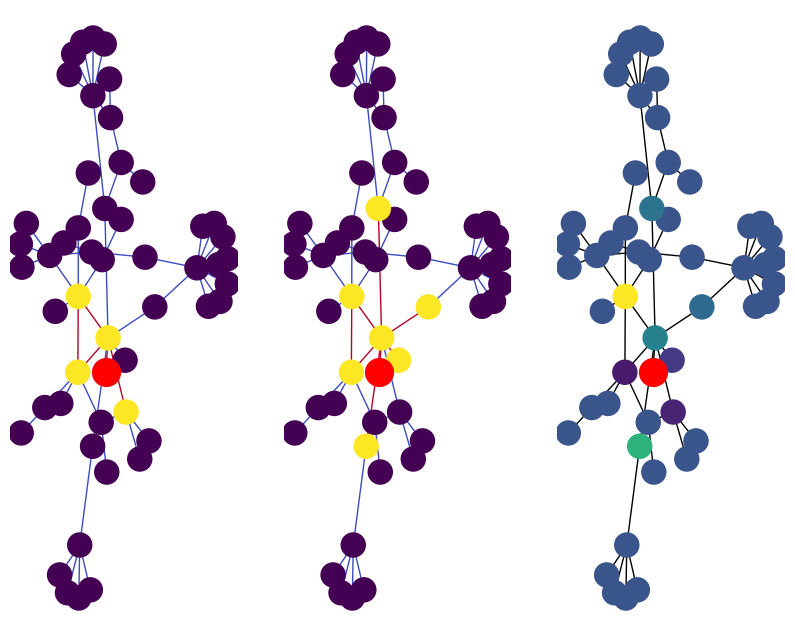

In [15]:
from torch_geometric.data import Data
from graphxai.explainers import PGExplainer, IntegratedGradExplainer

# Embedding layer name is final GNN embedding layer in the model
pgex = PGExplainer(model, emb_layer_name = 'gin2', max_epochs = 10, lr = 0.1)

# Required to first train PGExplainer on the dataset:
# Feed in entire data, the internal model uses the data's train mask
pgex.train_explanation_model(data)

# No training with Integrated Gradients, just run the model:
igex = IntegratedGradExplainer(model, criterion=criterion)

# Sample a random node for visualization. Also returns a ground truth explanation:
node_idx, gt_exp = dataset.choose_node(split = 'test')

# Get explanations from both IG and PGEx:
pgex_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

fig, ax = plt.subplots(1,3, figsize = (10, 8))

# Ground-truth explanations always provided as a list. In ShapeGGen, we use the first
#   element since it produces unique explanations.
gt_exp[0].visualize_node(num_hops = 3, graph_data = data, ax = ax[0])
pgex_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[1])
ig_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[2])

In [16]:
from graphxai.metrics import graph_exp_acc

# Accuracy for each method:
pg_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = pgex_exp)

# Threshold is the lower bound for which we consider a node to be "positive".
#   Here we take 80% of the maximum value for the node importance of integrated gradients.
ig_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = ig_exp, threshold = ig_exp.node_imp.max().item() * 0.8)

print('PGExplainer Accuracy: {:.4f}'.format(pg_acc))
print('Integrated Gradients Accuracy: {:.4f}'.format(ig_acc))

PGExplainer Accuracy: 0.3333
Integrated Gradients Accuracy: 0.2500


In [10]:
# Membuat file requirements dengan cara modern
!pip list --format=freeze > requirements.txt